# Mixtures of PPCA's
In this chapter, we introduce mixtures of PPCA models.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from utils import loadStan
sns.set()

In [115]:
moppcas_model = loadStan('moppcas', recompile=True)
ppca_model = loadStan('ppca')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4dc7996805fa08668353198f9d66bacf NOW.


Model compiled succesfully.
Model saved succesfully to cache.
Model loaded succesfully from cache.


In [3]:
N=1000
M=2
D=3
K=5
mu = np.random.uniform(-50,50,size=(K,D))
sigma = np.random.uniform(0,3,size=(K))
while True:      # make sure to not have a negligible cluster
    theta = np.random.dirichlet(np.ones(K))
    if np.all(theta>(1.0/(2*K))):
        break

z = []
W = []
for k in range(K):
    W.append(np.random.normal(0,1.5,size=(D,M)))
    z.append(np.random.normal(0,1, size=(M,N)))
    
x = np.zeros((N,D))
ind = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta)
    x[n,:] = np.random.normal(np.matmul(W[opt],z[opt][:,n])+mu[opt], sigma[opt])
    ind.append(opt)

print('theta: ', theta)
print()
for k in range(K):
    print('W_'+str(k)+':\n',W[k])
    print('mu_'+str(k)+': ',mu[k,:])
    print('sigma_'+str(k)+': ',sigma[k])
    print()

theta:  [0.11096152 0.16623668 0.11582115 0.18174853 0.42523213]

W_0:
 [[ 0.63486454  1.48890809]
 [ 1.04791139  0.88159705]
 [-1.61414059 -0.68423836]]
mu_0:  [ 49.07240935 -35.4228586   15.24609377]
sigma_0:  2.1856058768012776

W_1:
 [[-3.60008611  3.03325435]
 [ 0.20284512  0.62710989]
 [-0.9774261  -3.28259249]]
mu_1:  [ 21.91594584 -33.39377237  13.95426292]
sigma_1:  1.8605012196215278

W_2:
 [[ 1.16255149  2.39689664]
 [-0.07310926 -0.9989414 ]
 [-2.01349346 -0.74692714]]
mu_2:  [ 35.73007954 -25.55213602  19.78482417]
sigma_2:  1.9061211257570227

W_3:
 [[ 1.83136853 -0.00490751]
 [-0.29823836 -2.67457114]
 [ 1.17487407  1.87771961]]
mu_3:  [20.27165195 14.64276494 34.67411292]
sigma_3:  2.5685749890222445

W_4:
 [[ 0.1809237   0.97342617]
 [-0.5370145   1.16930531]
 [-0.79096451  2.27803558]]
mu_4:  [-25.6947025  -29.31221859  19.96115461]
sigma_4:  1.5470168507839257



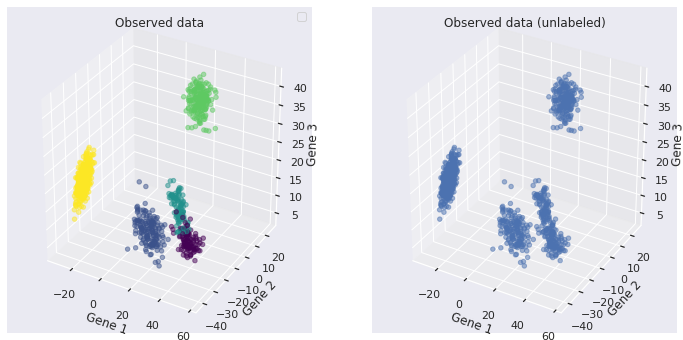

In [4]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], c=ind, cmap='viridis', alpha=0.5)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], cmap='viridis', alpha=0.5)
ax.set_title('Observed data (unlabeled)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

Since the optimization is highly dependend on the initial values, we initialize $\mu$ with a simple $k$-means clustering algorithm. It is also possible to initialize the inidivual factor laoding matrices $W_k$ as the factor loading matrix found when fitting a PPCA on the whole dataset.

In [14]:
ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x}
fit = ppca_model.sampling(data=ppca_dat, chains=1, iter=100)
W_init = np.mean(fit.extract()['W'], axis=0)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [116]:
kmeans_init = KMeans(K).fit(x)

gmm_dat = {'N': N, 'M': M, 'K': K, 'D':D, 'y':x}
fit = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':kmeans_init.cluster_centers_}])
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]
fit_W = moppcas_model.sampling(data=gmm_dat, chains=1, iter=100, init=[{'mu':kmeans_init.cluster_centers_, 'W':[W_init for k in range(K)]}])
fit_ext_W = fit_W.extract()
best_ind_W = np.where(fit_ext_W['lp__']==max(fit_ext_W['lp__']))[0][0]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [117]:
theta_sim = np.mean(fit_ext['theta'],axis=0)
mu_sim = np.mean(fit_ext['mu'],axis=0)
sigmas_sim = np.mean(fit_ext['sigma'],axis=0)
z_sim = fit_ext['z'][best_ind]
W_sim = np.mean(fit_ext['W'],axis=0)
clusters = np.mean(fit_ext['clusters'],axis=0)

theta_sim_W = np.mean(fit_ext_W['theta'],axis=0)
mu_sim_W = np.mean(fit_ext_W['mu'],axis=0)
sigmas_sim_W = np.mean(fit_ext_W['sigma'],axis=0)
z_sim_W = fit_ext_W['z'][best_ind_W]
W_sim_W = np.mean(fit_ext_W['W'],axis=0)
clusters_W = np.mean(fit_ext_W['clusters'],axis=0)

order = True         # this tries to set the simulated clusters in the same order as the original; good for testing, but costly for real use
if order:
    mu_diffs = np.ones((K,K))
    mu_diffs_W = np.ones((K,K))
    for i in range(K):
        for j in range(K):
            mu_diffs[i,j] = sum([(mu[i][d]-mu_sim[j][d])**2 for d in range(D)])
            mu_diffs_W[i,j] = sum([(mu[i][d]-mu_sim_W[j][d])**2 for d in range(D)])

    best_score = 10000
    best_score_W = 10000
    for perm in list(itertools.permutations(list(range(K)))):
        score = 0
        score_W = 0
        for i,j in enumerate(perm):
            score+=mu_diffs[i,j]
            score_W+=mu_diffs_W[i,j]
        if score<best_score:
            best_order = perm
            best_score = score
        if score_W<best_score_W:
            best_order_W = perm
            best_score_W = score_W
    
    theta_sim = np.array([theta_sim[i] for i in best_order])
    mu_sim = np.array([mu_sim[i] for i in best_order])
    sigmas_sim = np.array([sigmas_sim[i] for i in best_order])
    z_sim = [z_sim[i] for i in best_order]
    W_sim = np.array([W_sim[i] for i in best_order])
    clusters = np.array([clusters[:,i] for i in best_order]).T

    theta_sim_W = np.array([theta_sim_W[i] for i in best_order])
    mu_sim_W = np.array([mu_sim_W[i] for i in best_order])
    sigmas_sim_W = np.array([sigmas_sim_W[i] for i in best_order])
    z_sim_W = [z_sim_W[i] for i in best_order]
    W_sim_W = np.array([W_sim_W[i] for i in best_order])
    clusters_W = np.array([clusters_W[:,i] for i in best_order]).T

print('Real theta: ',theta)
print('Sample theta: ',[sum(np.array(ind)==k)/N for k in range(K)])
print('Simulated theta: ',theta_sim)
print('Simulated theta (initialized W): ',theta_sim_W)
print()
print('actual mu:\n',mu)
print('Simulated mu:\n',mu_sim)
print('Simulated mu (initialized W):\n',mu_sim_W)
print()
print('actual sigmas: ',sigma)
print('Simulated sigmas: ',sigmas_sim)
print('Simulated sigmas (initialized W): ',sigmas_sim_W)
print()
for k in range(K):
    print('Actual WW^T_'+str(k+1)+': ')
    print(np.matmul(W[k],W[k].T))
    print('Simulated WW^T_'+str(k+1)+': ')
    print(np.matmul(W_sim[k],W_sim[k].T))
    print('Simulated WW^T_'+str(k+1)+' (initialized W): ')
    print(np.matmul(W_sim_W[k],W_sim_W[k].T))
    print()

clusters_norm = (np.exp(clusters).T/sum(np.exp(clusters).T)).T
z_cats = np.argmax(clusters_norm, axis=1)
clusters_norm_W = (np.exp(clusters_W).T/sum(np.exp(clusters_W).T)).T
z_cats_W = np.argmax(clusters_norm_W, axis=1)

Real theta:  [0.11096152 0.16623668 0.11582115 0.18174853 0.42523213]
Sample theta:  [0.106, 0.159, 0.093, 0.191, 0.451]
Simulated theta:  [0.10718372 0.15525005 0.10520412 0.19171995 0.44064217]
Simulated theta (initialized W):  [0.16778765 0.19811458 0.3121023  0.17101213 0.15098335]

actual mu:
 [[ 49.07240935 -35.4228586   15.24609377]
 [ 21.91594584 -33.39377237  13.95426292]
 [ 35.73007954 -25.55213602  19.78482417]
 [ 20.27165195  14.64276494  34.67411292]
 [-25.6947025  -29.31221859  19.96115461]]
Simulated mu:
 [[ 49.50094865 -35.13341481  15.21796432]
 [ 22.33247758 -33.48801597  13.57492431]
 [ 36.12969834 -25.51693142  19.07673057]
 [ 20.39049051  14.46611741  35.01532305]
 [-25.62258722 -29.18775175  19.88885151]]
Simulated mu (initialized W):
 [[ 23.60049795 -29.00235435  17.29555171]
 [  9.26584031 -28.46212027  17.79439469]
 [-19.26910355 -26.48862907  20.51542407]
 [ 13.33740397   3.85426749  31.42411039]
 [ 15.96243359 -24.14965644  20.2673916 ]]

actual sigmas:  [2.1

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


In [118]:
x_rec = np.zeros((N,D))
ind_rec = []
x_rec_W = np.zeros((N,D))
ind_rec_W = []
for n in range(N):
    opt = np.random.choice(list(range(K)),p=theta_sim)
    x_rec[n,:] = np.random.normal(np.matmul(W_sim[opt],z_sim[opt][:,n])+mu_sim[opt], sigmas_sim[opt])
    ind_rec.append(opt)
    opt = np.random.choice(list(range(K)),p=theta_sim_W)
    x_rec_W[n,:] = np.random.normal(np.matmul(W_sim_W[opt],z_sim_W[opt][:,n])+mu_sim_W[opt], sigmas_sim_W[opt])
    ind_rec_W.append(opt)

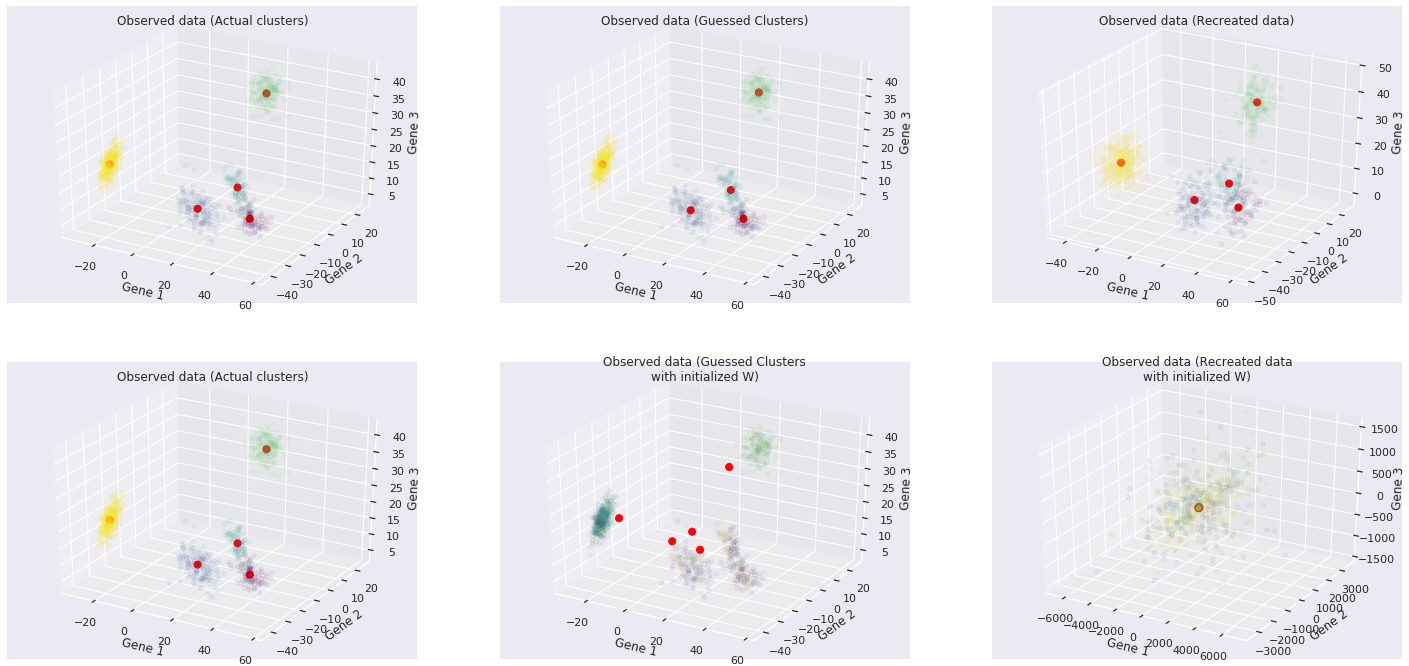

In [119]:
fig = plt.figure(figsize=(25,12))
ax = fig.add_subplot(2,3,1, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=ind, cmap='viridis', alpha=0.05)
ax.scatter(mu[:,0],mu[:,1],mu[:,2], c='red', s=50, zorder=2, alpha=1)
ax.set_title('Observed data (Actual clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,2, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=z_cats, cmap='viridis', alpha=0.05,zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Guessed Clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,3, projection='3d')
ax.scatter(x_rec[:,0],x_rec[:,1],x_rec[:,2],c=ind_rec, cmap='viridis', alpha=0.05, zorder=1)
ax.scatter(mu_sim[:,0],mu_sim[:,1],mu_sim[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Recreated data)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,4, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=ind, cmap='viridis', alpha=0.05)
ax.scatter(mu[:,0],mu[:,1],mu[:,2], c='red', s=50, zorder=2, alpha=1)
ax.set_title('Observed data (Actual clusters)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,5, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2],c=z_cats_W, cmap='viridis', alpha=0.05,zorder=1)
ax.scatter(mu_sim_W[:,0],mu_sim_W[:,1],mu_sim_W[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Guessed Clusters\nwith initialized W)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')

ax = fig.add_subplot(2,3,6, projection='3d')
ax.scatter(x_rec_W[:,0],x_rec_W[:,1],x_rec_W[:,2],c=ind_rec, cmap='viridis', alpha=0.05, zorder=1)
ax.scatter(mu_sim_W[:,0],mu_sim_W[:,1],mu_sim_W[:,2], c='red', s=50, alpha=1, zorder=2)
ax.set_title('Observed data (Recreated data\nwith initialized W)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

The red dots in the above plot illustrate the real (left figure) and estimated (centre and right figure) values of $\mu$. (They are not always perfectly visible though, sorry for the inconvenience.)
Clearly, initializing $W$ did not help our algorithm. We'll leave it out in the future.

In [120]:
for k in range(K):
    print('Actual mean of latent cluster '+str(k), np.mean(z[k],axis=1))
    print('Actual std. dev of latent cluster '+str(k), np.std(z[k],axis=1))
    print('Estimated mean of latent cluster '+str(k), np.mean(z_sim[k],axis=1))
    print('Estimated std. dev of latent cluster '+str(k), np.std(z_sim[k],axis=1))
    print()

Actual mean of latent cluster 0 [-0.04605     0.07762799]
Actual std. dev of latent cluster 0 [1.02849408 1.0240371 ]
Estimated mean of latent cluster 0 [-0.01834085  0.04058772]
Estimated std. dev of latent cluster 0 [1.26476364 1.20968296]

Actual mean of latent cluster 1 [-0.01635583  0.0098377 ]
Actual std. dev of latent cluster 1 [1.00477273 0.95350804]
Estimated mean of latent cluster 1 [-0.03318514  0.0257932 ]
Estimated std. dev of latent cluster 1 [1.26074346 1.23343189]

Actual mean of latent cluster 2 [-0.04185148 -0.03932384]
Actual std. dev of latent cluster 2 [0.99617578 0.990541  ]
Estimated mean of latent cluster 2 [-0.00265105  0.06731271]
Estimated std. dev of latent cluster 2 [1.25622705 1.24877444]

Actual mean of latent cluster 3 [0.05496599 0.00461628]
Actual std. dev of latent cluster 3 [1.03345469 1.00299536]
Estimated mean of latent cluster 3 [ 0.01231406 -0.04633839]
Estimated std. dev of latent cluster 3 [1.26305643 1.26622557]

Actual mean of latent cluster 

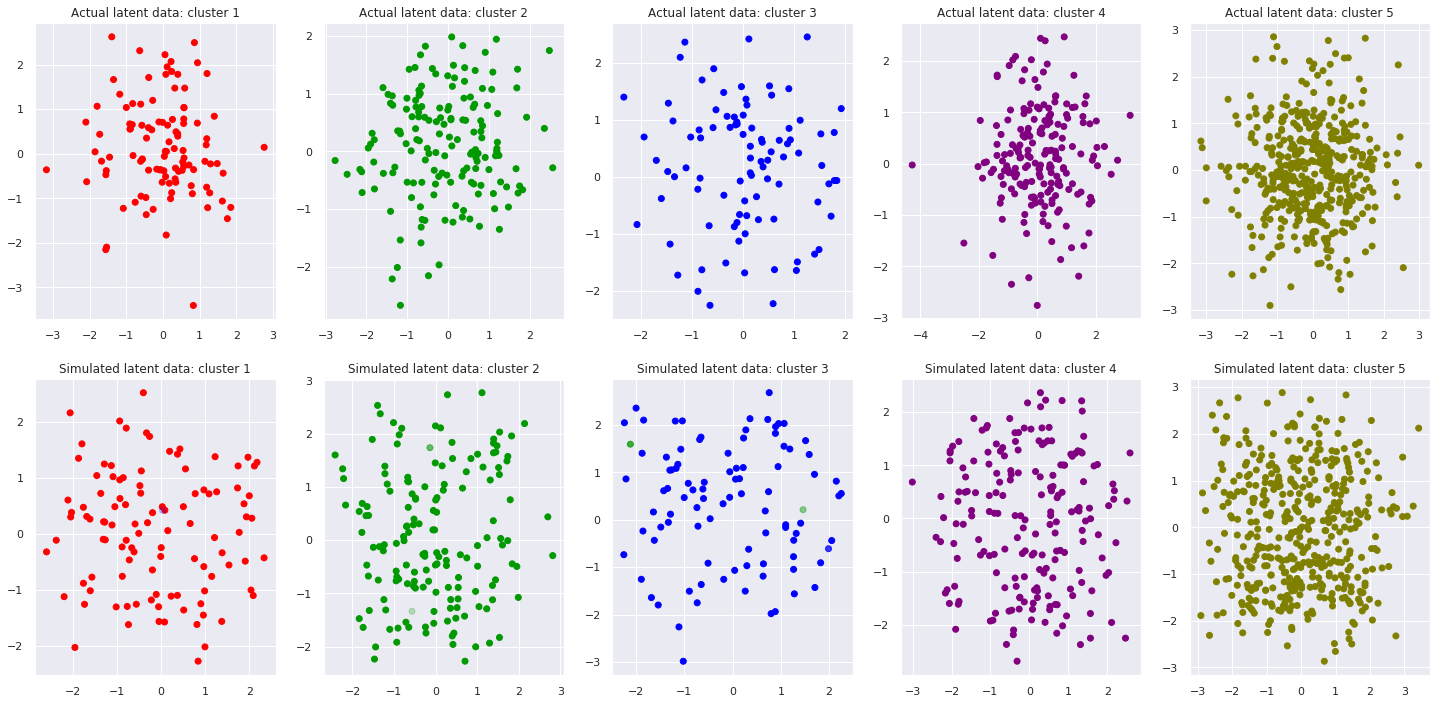

Cluster 0:
Real sample mean:  [-0.01712081  0.14228225]
Simulated (weighted) mean:  [-0.12389003  0.05438449]
Real sample std. dev.:  [0.99633838 1.07315225]
Simulated (weighted) std. dev.:  1.277488282456213 1.0589983343729368

Cluster 1:
Real sample mean:  [-0.06223975  0.10693612]
Simulated (weighted) mean:  [-0.03821788  0.07059116]
Real sample std. dev.:  [1.05689824 0.91164813]
Simulated (weighted) std. dev.:  1.1314128065737943 1.2429892643197316

Cluster 2:
Real sample mean:  [0.03303094 0.19464379]
Simulated (weighted) mean:  [-0.09496251  0.32409524]
Real sample std. dev.:  [0.97589089 1.08531877]
Simulated (weighted) std. dev.:  1.2243058542460514 1.263252664158552

Cluster 3:
Real sample mean:  [0.09065266 0.1500085 ]
Simulated (weighted) mean:  [-0.00511364 -0.05475304]
Real sample std. dev.:  [1.0480442  0.93918171]
Simulated (weighted) std. dev.:  1.2125107597423441 1.243286998126191

Cluster 4:
Real sample mean:  [-0.05488646  0.00168027]
Simulated (weighted) mean:  [-0

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt


In [121]:
cols = [[1,0,0], [0,0.6,0],[0,0,1],[0.5,0,0.5],[0.5,0.5,0]]

sns.set()
vis_threshold = 0.001

fig = plt.figure(figsize=(25,12))
for k in range(K):
    ax = fig.add_subplot(2,K,k+1)
    ax.scatter(z[k][0,np.array(ind)==k],z[k][1,np.array(ind)==k], c=np.outer(np.ones(len(z[k][0,np.array(ind)==k])),cols[k]))
    ax.set_title('Actual latent data: cluster '+str(k+1))
    
for k in range(K):
    ax = fig.add_subplot(2,K,K+k+1)
    plotz = z_sim[k][:,clusters_norm[:,k]>vis_threshold]
    rgba_colors = np.zeros((sum(clusters_norm[:,k]>vis_threshold),4))
    for k_i in range(K):
        rgba_colors[np.array(ind)[clusters_norm[:,k]>vis_threshold]==k_i,:3] = cols[k_i]
    rgba_colors[:, 3] = clusters_norm[:,k][clusters_norm[:,k]>vis_threshold]
    ax.scatter(plotz[0,:],plotz[1,:], c=rgba_colors)
    ax.set_title('Simulated latent data: cluster '+str(k+1))
    
plt.show()

for k in range(K):
    weights = clusters_norm[:,k]
    zbark = z_sim[k]
    print('Cluster '+str(k)+':')
    print('Real sample mean: ', np.mean(z[k][:,np.array(ind)==k],axis=1))
    weigh_mu_sim = np.sum(zbark*weights,axis=1)/sum(weights)
    print('Simulated (weighted) mean: ', weigh_mu_sim)
    print('Real sample std. dev.: ',np.std(z[k][:,np.array(ind)==k],axis=1))
#     M_v = sum(clusters[:,k]>0.0)
    weighted_cov = np.sqrt(np.cov(zbark, aweights=weights))
    print('Simulated (weighted) std. dev.: ', weighted_cov[0,0],weighted_cov[1,1])
#     print('Simulated (weighted) std. dev.: ', np.sqrt(np.sum(np.square(zbark.T-weigh_mu_sim).T*weights,axis=1)/(sum(weights)*((M_v-1)/M_v))))
    print()

And we end up with all all latent data in separate clusters!